In [2]:
import os
# Check if the kaggle.json file is in the correct location
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d jeffheaton/demand-forecasting-with-tabular-textual-images

Dataset URL: https://www.kaggle.com/datasets/jeffheaton/demand-forecasting-with-tabular-textual-images
License(s): CC-BY-SA-4.0
 93% 117M/126M [00:01<00:00, 75.7MB/s]
100% 126M/126M [00:01<00:00, 89.0MB/s]


In [4]:
import zipfile
with zipfile.ZipFile('/content/demand-forecasting-with-tabular-textual-images.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
import numpy as np
import pandas as pd

In [6]:
df_sales=pd.read_csv('/content/beach_demand_forecast/sales_train.csv')

In [7]:
df_restraunt=pd.read_csv('/content/beach_demand_forecast/resturants.csv')
df_items=pd.read_csv('/content/beach_demand_forecast/items.csv')

In [8]:
df_sales.date = pd.to_datetime(df_sales.date, errors='coerce')

In [9]:
df_sales['weekday'] = df_sales.date.dt.day_name()

In [10]:
start_date = df_sales.date.min()
df_sales['week'] = (((df_sales.date - start_date).dt.days) / 7).astype(int)

In [11]:
import plotly.express as px

df_plot = df_sales[['date','item_count']].groupby(['date']).sum().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='Total Sales by Date')
fig.show()

In [12]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Obtain data aggregated by weekday.
df_plot = df_sales[['weekday','item_count']].groupby(['weekday']).sum().reset_index()
# Sort by day of week
df_plot = df_plot.set_index("weekday").loc[day_order].reset_index()

fig = px.bar(df_plot, x='weekday', y='item_count', title='Total Sales by Day of Week')
fig.show()

In [13]:
df2 = df_sales[['item_id','item_count']].groupby(['item_id']).sum().reset_index().sort_values('item_count',ascending=False)
df_items2 = df_items[['id','name']]
df_items2.columns = ['item_id','name']
df_popular = df2.merge(df_items2)
print(df_popular.to_string())

    item_id  item_count                                                  name
0        19    236337.0                                    Strawberry Smoothy
1        16    102990.0                                  Frozen Milky Smoothy
2        76     61043.0                                    Amazing pork lunch
3        38     52772.0                                         Mutton Dinner
4         9     43874.0                                          Orange Juice
5        59     42774.0                               Blue Ribbon Beef Entree
6         4     34439.0                       Amazing Steak Dinner with Rolls
7        13     27490.0                               Sweet Frozen Soft Drink
8        56     23839.0                       Sea Bass with Vegetables Dinner
9        67     18764.0                                       Sweet Lamb Cake
10       21     13190.0                     Amazing Fish with Vegetables Meal
11       12      7791.0                                  Fantast

In [14]:
train_size = 0.7

# Calculate the index to split the data
split_index = int(len(df_sales) * train_size)

train_df = df_sales.iloc[:split_index].groupby('date')['item_count'].sum().reset_index()
test_df = df_sales.iloc[split_index:].groupby('date')['item_count'].sum().reset_index()

In [15]:
train_df.set_index('date', inplace=True)
train_df.index = pd.DatetimeIndex(train_df.index).to_period('D')
test_df.set_index('date', inplace=True)
test_df.index = pd.DatetimeIndex(test_df.index).to_period('D')

In [16]:
train_df = train_df.asfreq('D')

In [17]:
train_df = train_df.resample('D').mean()  # Resample to daily and take the mean
train_df['item_count'].interpolate(method='linear', inplace=True)  # Fill missing values

<ipython-input-17-d38c7408b07d>:1: FutureWarning:

Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.

<ipython-input-17-d38c7408b07d>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

<ipython-input-19-2080c84e1ecd>:1: FutureWarning:

Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.

<ipython-input-19-2080c84e1ecd>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





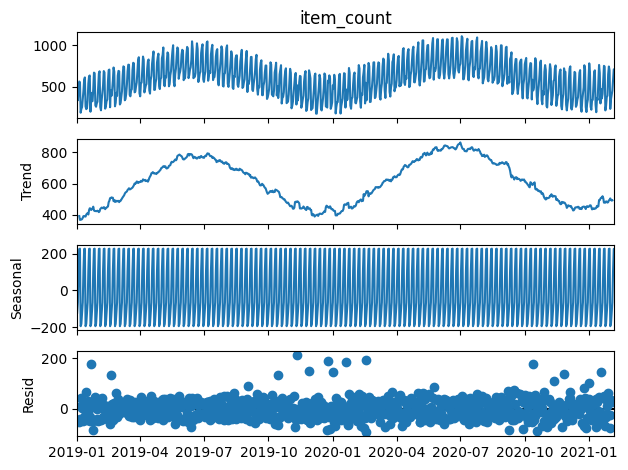

In [19]:
train_df = train_df.resample('D').mean()  # Resample to daily and take the mean
train_df['item_count'].interpolate(method='linear', inplace=True)  # Fill missing values

if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df.index = train_df.index.to_timestamp() # Use to_timestamp() for PeriodIndex

decomp = seasonal_decompose(train_df['item_count'], model='additive', period=7)
decomp.plot()
plt.show()  # Add plt.show() to display the plot

In [20]:
from sklearn.linear_model import LinearRegression

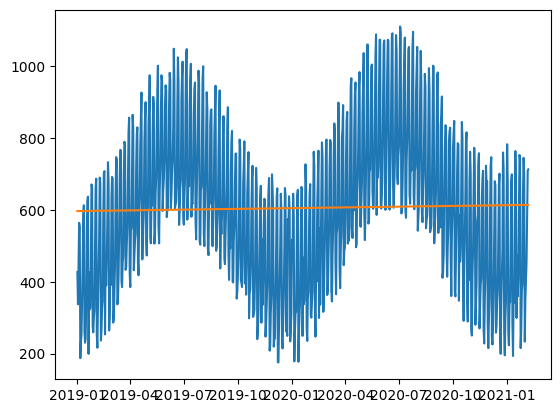

In [21]:
# Step 1: Detrending using linear regression
X = np.arange(len(train_df)).reshape(-1, 1)

trend_model = LinearRegression()
trend_model.fit(X, train_df['item_count'].values)

train_df['trend'] = trend_model.predict(X)
plt.plot(train_df['item_count'])
plt.plot(train_df['trend'])

In [22]:
train_df['detrend'] = train_df['item_count'] - train_df['trend']

In [23]:
train_df.index = pd.to_datetime(train_df.index)
seasonal_indices = train_df['detrend'].groupby(train_df.index.day_name()).mean()

In [24]:
seasonal_component_df = seasonal_indices.to_frame(name='weekly_seasonality')

In [25]:
seasonal_component_df

,weekly_seasonality
date,
Friday,223.884351
Monday,-180.670566
Saturday,225.652816
Sunday,-193.060966
Thursday,106.297704
Tuesday,-120.730136
Wednesday,-64.770762


In [26]:
train_df = train_df.merge(seasonal_component_df, left_on=train_df.index.day_name(), right_index=True)

In [27]:
train_df['with_yearly_seasonality'] = train_df['detrend'] - train_df['weekly_seasonality']

In [28]:
train_df.drop(columns=['key_0'], inplace=True)

In [29]:
seasonal_indices = train_df['with_yearly_seasonality'].groupby(train_df.index.month).mean()

In [30]:
yearly_seasonal_component_df = seasonal_indices.to_frame(name='yearly_seasonality')

In [31]:
train_df = train_df.merge(yearly_seasonal_component_df, left_on=train_df.index.month, right_index=True)

In [32]:
train_df

,key_0,item_count,trend,detrend,weekly_seasonality,with_yearly_seasonality,yearly_seasonality
date,,,,,,,
2019-01-01,1,427.0,596.776949,-169.776949,-120.730136,-49.046813,-165.871253
2019-01-02,1,337.0,596.799393,-259.799393,-64.770762,-195.028631,-165.871253
2019-01-03,1,445.0,596.821837,-151.821837,106.297704,-258.119540,-165.871253
2019-01-04,1,564.0,596.844280,-32.844280,223.884351,-256.728631,-165.871253
2019-01-05,1,552.0,596.866724,-44.866724,225.652816,-270.519540,-165.871253
...,...,...,...,...,...,...,...
2021-02-02,2,401.0,613.901505,-212.901505,-120.730136,-92.171369,-108.299263
2021-02-03,2,455.0,613.923949,-158.923949,-64.770762,-94.153187,-108.299263
2021-02-04,2,586.0,613.946393,-27.946393,106.297704,-134.244096,-108.299263


In [33]:
train_df['stationary'] = train_df['with_yearly_seasonality'] - train_df['yearly_seasonality']

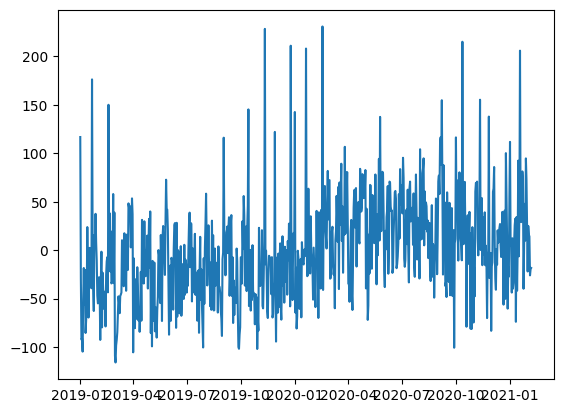

In [34]:
plt.plot(train_df['stationary'])

In [35]:
# Define the number of input samples
n_input = 10

# Initialize lists to store input sequences and target values
X = []
y = []

# Iterate through the data to create sequences
for i in range(len(train_df['stationary'].diff().dropna()) - n_input):
    # Extract input sequence and target value
    seq_x = np.array(train_df['stationary'].diff().dropna())[i:i+n_input] # Extract first column for input sequence
    seq_y = np.array(train_df['stationary'].diff().dropna())[i+n_input]    # Extract target value from first column

    # Append the sequences and target values to the lists
    X.append(seq_x)
    y.append(seq_y)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

# Reshape X to match the input shape required by the model (batch_size, timesteps, features)
X = X.reshape((X.shape[0], n_input, 1))  # Assuming one feature per input sequence

print("Input sequences shape:", X.shape)
print("Target values shape:", y.shape)

Input sequences shape: (757, 10, 1)
Target values shape: (757,)


In [36]:
from tensorflow.keras.models import Sequential
from keras.layers import *

In [37]:
# Define model
model = Sequential()
model.add(InputLayer(input_shape=(n_input, 1)))
model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 512)             │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 10, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100)                 │         122,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,307,669 (4.99 MB)

 Trainable params: 1,307,669 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.fit(X,y,epochs=90, verbose = 0)

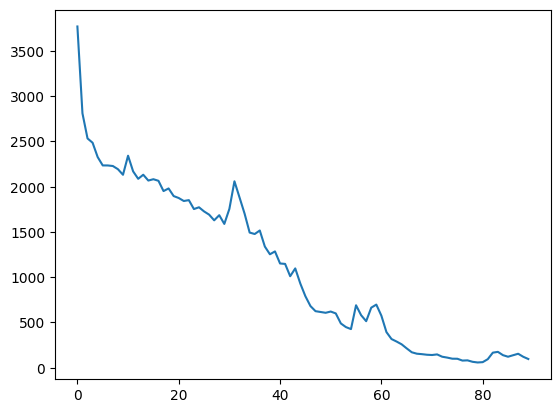

In [42]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [43]:
test_predictions = []

first_eval_batch = X[-1]
current_batch = first_eval_batch.reshape((1, n_input, 1))

for i in range(len(test_df)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=0)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [50]:
# Get seasonality components
test_yearly_seasonality = test_df.merge(
    yearly_seasonal_component_df,
    left_on=test_df.index.month,
    right_index=True
)['yearly_seasonality']

# Convert the PeriodIndex to a DateTimeIndex before using day_name()
test_weekly_seasonality = test_df.merge(
    seasonal_component_df,
    left_on=test_df.index.to_timestamp().day_name(), # Convert to DateTimeIndex
    right_index=True
)['weekly_seasonality']

# Calculate trend component
X_test = np.arange(len(train_df), len(train_df) + len(test_df)).reshape(-1, 1)
trend_test = trend_model.predict(X_test)

# Combine components
trend_seasonality = (
    test_yearly_seasonality +
    test_weekly_seasonality +
    trend_test
)

In [52]:
ac = test_df['item_count'] - trend_seasonality

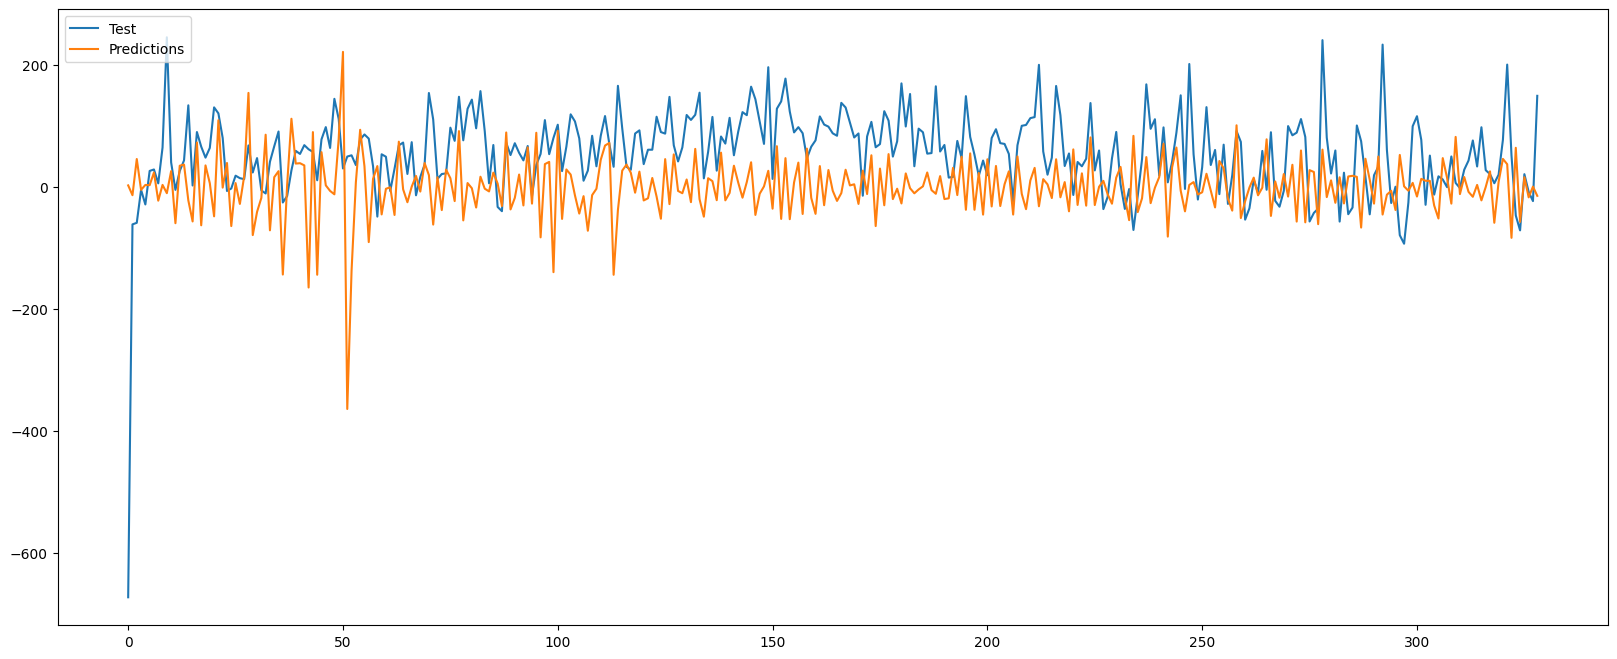

In [59]:
plt.figure(figsize=(20,8))
# plt.plot(train_df['item_count'], label='Training')
plt.plot(np.array(ac), label='Test')
plt.plot(test_predictions, label='Predictions')
plt.legend(loc = 'upper left')
plt.show()

329

<Figure size 2000x800 with 0 Axes>

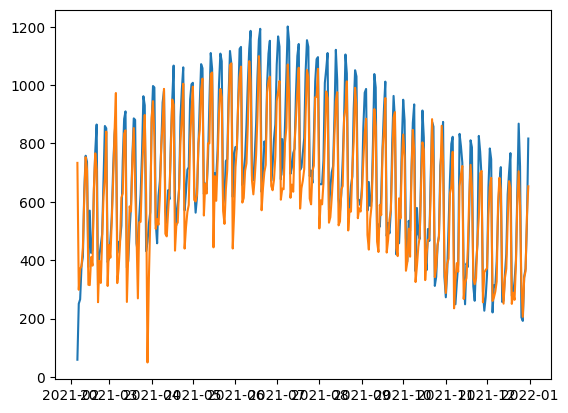

<Figure size 2000x800 with 0 Axes>

In [69]:
Y_hat = np.array(test_predictions).flatten() + trend_seasonality
# Convert the index of test_df to DateTimeInd
# Convert the index of Y_hat to a DateTimeIndex
Y_hat.index = Y_hat.index.to_timestamp()

plt.plot(test_df['item_count'])
plt.plot(Y_hat) # Now plotting with a DateTimeIndex
plt.figure(figsize=(20,8))

In [67]:
from sklearn.metrics import mean_squared_error

In [68]:
# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(np.array(test_df['item_count']),Y_hat ))
print("Root Mean Squared Error (RMSE):", rmse_lstm)

# Mean Absolute Error (MAE)
mae_lstm = np.mean(np.abs(np.array(test_df['item_count']) - Y_hat))
print("Mean Absolute Error (MAE):", mae_lstm)

# Mean Absolute Percentage Error (MAPE)
mape_lstm = np.mean(np.abs((np.array(test_df['item_count']) - Y_hat) / np.array(test_df['item_count']))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

Root Mean Squared Error (RMSE): 100.68950379001284
Mean Absolute Error (MAE): 76.19946761803074
Mean Absolute Percentage Error (MAPE): 14.874771684028442


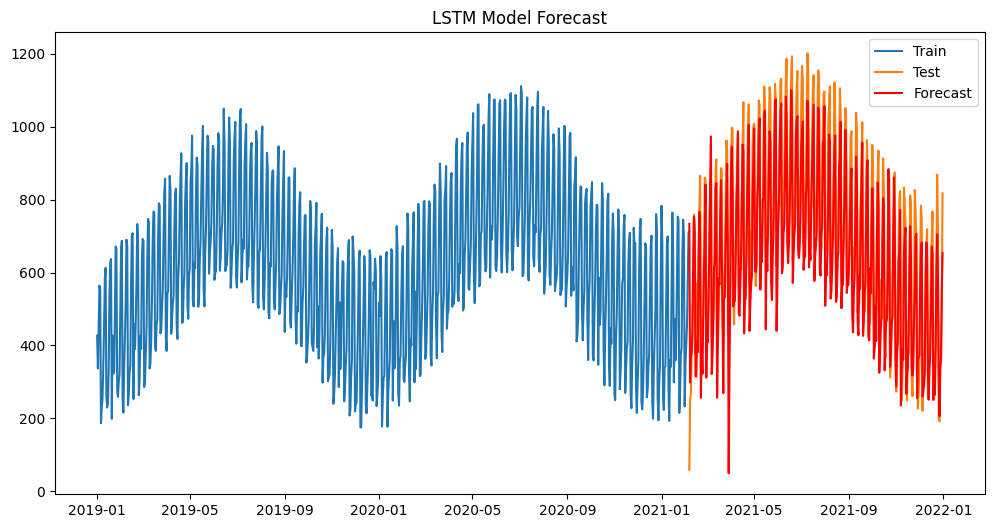

In [71]:

plt.figure(figsize=(12, 6))
plt.plot(train_df['item_count'], label='Train')
plt.plot(test_df['item_count'], label='Test')
plt.plot(Y_hat, label='Forecast', color='red')
plt.legend()
plt.title('LSTM Model Forecast')
plt.show()